# NR band notebook

Erik Hogenbirk, May 2017

### Imports

In [1]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers.ipynb'

# Specific to this analysis
# %run 'definitions.ipynb'

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Analysis class

In [2]:
%run '../Analysis_class.ipynb'

## New analysis

In [14]:
local_data = False

if local_data:
    processed_data_path_er = '/home/erik/win/data/xams_run8/processed/er/'
    processed_data_path_nr = '/home/erik/win/data/xams_run8/processed/ambe/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path_nr = '/data/xenon/xams/run8/processed_v2/'
    processed_data_path_er = '/data/xenon/xams/run8/processed_v2/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [15]:
run_names_nr = get_run_list(processed_data_path_nr, '170321_155957', '170321_155957') # 170322_081037
run_names_er = get_run_list(processed_data_path_er, '170323_144804', '170323_144804') # 170323_151843 (Cs)

Run list contains 1 files
Run list contains 1 files


In [18]:
x = XAMSAnalysis(run_names_nr, processed_data_path_nr, minitree_path)

In [21]:
x.load()

Loaded 78884 (78.9 k) events.


Finite s1 selection: 23385 rows removed (70.36% passed)


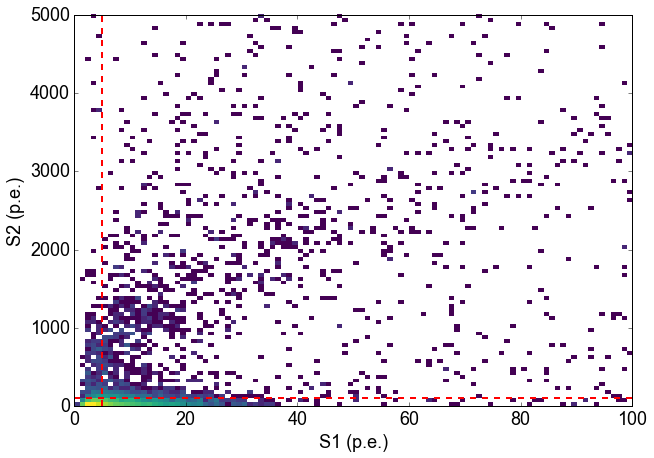

s1 above 5 selection: 2474 rows removed (95.54% passed)
s2 above 100 selection: 2906 rows removed (94.52% passed)


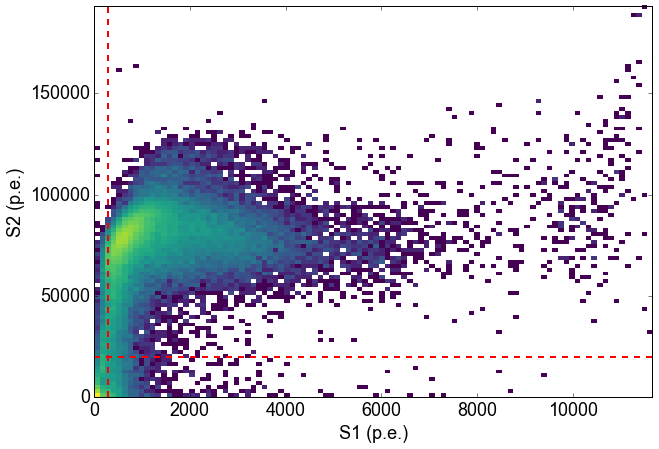

s1 below 300 selection: 43932 rows removed (12.34% passed)
s2 below 20000.0 selection: 2543 rows removed (58.90% passed)
largest_other_s1 below 5 selection: 505 rows removed (86.14% passed)


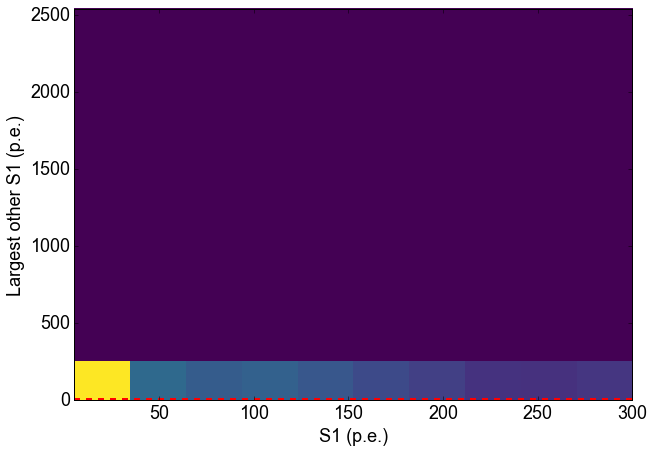

In [20]:
x.cut_interaction_exists()
x.cut_thresholds(5, 100, plot=True, bins=100, norm=LogNorm(), range=((0, 100), (0, 5000)))
x.cut_low_energy(300, 20e3, plot=True, bins=100, norm=LogNorm())
x.cut_largest_other_s1(plot=True)

In [ ]:
x.cuts_apply_all()

In [ ]:
x.corr_s1_ly()

In [ ]:
x.corr_s2_sag((200, 250), bins=10, plot=True)

In [ ]:
x.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 300), (0, 15000)))

## OLD ANALYSIS

### Read data

In [ ]:
# Compute the difference from the trend
d_nr['s1_aft_difference'] = d_nr['s1_area_fraction_top'] - f_s1_aft(d_nr['drift_time'])

# Get the upper and lower percentiles...
x, y_upper = get_trend(d_nr['s1'], d_nr['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile', pct=95)
x, y_lower = get_trend(d_nr['s1'], d_nr['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile',pct=5)

# ... And their interpolation...
f_lower = my_interp(x, y_lower, kind='cubic')
f_upper = my_interp(x, y_upper, kind='cubic')

In [ ]:
plt.hist2d(d_nr['s1'], d_nr['s1_aft_difference'], bins=100, range=((0, 400), (-0.5, 0.5)), norm=LogNorm())
plt.axhline(0, color='black')
x_plot = np.linspace(0, 400, 400)

plt.plot(x_plot, f_upper(x_plot), color='red', label='Interpolation')
plt.plot(x_plot, f_lower(x_plot), color='red')
plt.scatter(x, y_upper, s=10, color='red', label='Binned percentile')
plt.scatter(x, y_lower, s=10, color='red')
plt.xlabel('S1 (a.u.)')
plt.ylabel('Difference from mean AFT')
plt.show()

In [ ]:
d_nr['AFT_Upper'] = (d_nr['s1_aft_difference'] < f_upper(d_nr['s1'])) # Add boolean variable
d_nr['AFT_Lower'] = (d_nr['s1_aft_difference'] > f_lower(d_nr['s1']))
d_nr = cuts.selection(d_nr, d_nr['AFT_Upper'], 'AFT_Upper')
d_nr = cuts.selection(d_nr, d_nr['AFT_Lower'], 'AFT_Lower')

### Drift time

In [ ]:
d_er = cuts.range_selection(d_er, 'drift_time', (0, 60))
d_nr = cuts.range_selection(d_nr, 'drift_time', (0, 60))

## What have we got

In [ ]:
plt_s1s2(d_er['s1'], d_er['s2'], bins=100, norm=LogNorm())

In [ ]:
plt_s1s2(d_nr['s1'], d_nr['s2'], bins=100, norm=LogNorm())

## Corrections

In [ ]:
# Import the correction from Cs calibration
import pickle
# Interpolate light curve
x_cs, y_cs = pickle.load(open('../light_yield/xy_cs', 'rb'))
f_s1_corr_cs = my_interp(x_cs, y_cs)

def get_cs1(s1, z, f_s1_corr):
    average_s1 = np.average([f_s1_corr(_z) for _z in np.linspace(-10, 0, 100)])
    return s1/f_s1_corr(z) * average_s1

d_er['cs1']= get_cs1(d_er['s1'], d_er['z'], f_s1_corr_cs)
d_nr['cs1']= get_cs1(d_nr['s1'], d_nr['z'], f_s1_corr_cs)

### Compare

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.hist2d(d_nr['s1'], d_nr['s2'], bins=100, norm=LogNorm(), range=((0, 300), (0, 30e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')

plt.subplot(122)
plt.hist2d(d_nr['cs1'], d_nr['s2'], bins=100, norm=LogNorm(), range=((0, 300), (0, 30e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')


plt.show()

In [ ]:
d_nr['t'] = (d_nr['event_time'] - d_nr['event_time'].values[0]) * 1e-9
d_er['t'] = (d_er['event_time'] - d_er['event_time'].values[0]) * 1e-9

In [ ]:
edges = (200, 250)
_d = d_nr[(d_nr['cs1'] > edges[0]) & (d_nr['cs1'] < edges[1])]
_d2 = d_er[(d_er['cs1'] > edges[0]) & (d_er['cs1'] < edges[1])]


plt.hist(_d['s2'], bins=100, histtype='step')
plt.hist(_d2['s2'], bins=100, histtype='step')
plt.show()

plt.scatter(_d['t'], _d['s2'])
plt.show()

### Too low S2 population?

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.hist2d(d_er['cs1'], d_er['s2'], bins=100, norm=LogNorm(), range=((0, 1000), (0, 60e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')

plt.subplot(122)
plt.hist2d(d_er['s1'], d_er['s2'], bins=100, norm=LogNorm(), range=((0, 1000), (0, 60e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')
draw_box((150, 200), (2000, 5000))


plt.show()

In [ ]:
manna = (d_er['cs1'] > 150) & (d_er['cs1'] < 200) & (d_er['cs2'] > 2000) & (d_er['cs2'] < 5000)
d_er[manna][['event_number', 's1', 's2', 'drift_time']].head()

In [ ]:
d_er.keys()

In [ ]:
plt.scatter(d_er['cs1'], d_er['s2'], edgecolor='None', c=d_er['event_time'])
plt.colorbar()
plt.xlim(0, 200)
plt.ylim(0, 10000)

### Position

In [ ]:
z_bounds = (-9, -1)

In [ ]:
plt.hist(d_er['z'], histtype='step', bins=100)
for _l in z_bounds:
    plt.axvline(_l, color='red')
plt.show()

### S2 width

In [ ]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm())
plt.show()

In [ ]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm(), range=((-12, 0), (0, 1000)))
plt.show()

In [ ]:
from pax import units, configuration
PAX_CONFIG = configuration.load_configuration('XENON1T')

In [ ]:
def s2_width_model(z):
    diffusion_constant = PAX_CONFIG['WaveformSimulator']['diffusion_constant_liquid']
    v_drift = 1.68 * units.km/units.s

    w0 = 348.6 * units.ns
    return np.sqrt(w0 ** 2 - 4.0325 * diffusion_constant * z / v_drift ** 3)

In [ ]:
s2_range_fraction = (0.8, 1.2)

In [ ]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm(), range=((-12, 0), (0, 1000)))
x_plt = np.linspace(z_bounds[0], z_bounds[1], 100)
plt.plot(x_plt, s2_width_model(x_plt))

plt.fill_between(x_plt, s2_range_fraction[0] * s2_width_model(x_plt), s2_range_fraction[1] * s2_width_model(x_plt),
                color='red', alpha=0.2)

plt.show()

In [ ]:
d_er = cuts.range_selection(d_er, 'z', z_bounds)

In [ ]:
d_er = cuts.selection(d_er, (
        (d_er['s2_range_50p_area'] > s2_range_fraction[0] * s2_width_model(d_er['z'])) &
        (d_er['s2_range_50p_area'] < s2_range_fraction[1] * s2_width_model(d_er['z']))),
                      'S2 width cut')

In [ ]:
plt_s1s2(d_er['s1'], d_er['s2'], bins=(100,100), range=((0, 200), (0, 20e3)), norm=LogNorm())

plt.show()

In [ ]:
plt.hist2d(d_er['z'], d_er['s1_area_fraction_top'], bins=100, norm=LogNorm())
plt.show()